https://github.com/cyhong549/DeepFM-Keras/blob/master/keras_FM.py  
해당 깃헙 참조해서 모델 생성

In [1]:
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.base import BaseEstimator

from keras.layers import Input, Embedding, Dense,Flatten,\
    Concatenate,dot,Activation,Reshape,BatchNormalization,concatenate,Dropout,add,\
    RepeatVector,merge,multiply,Lambda
from keras.models import Model
from keras.regularizers import l2 as l2_reg
#from keras import initializations
import itertools
from keras import backend  as KK
from keras.engine.topology import Layer
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

Using TensorFlow backend.


## Data Loading

In [2]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df.csv"))
df.head()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr
0,788542,마르코 폴로,EAT,5.0,20180314,0,0,1,20,0.05,3.95,4.363636,11,14256,1,서울 강남구 삼성동 159-1 트레이드타워 52층
1,788542,마르코 폴로,EAT,4.0,20171207,0,0,1,20,0.05,3.95,4.000000,6,722,1,서울 강남구 삼성동 159-1 트레이드타워 52층
2,788542,마르코 폴로,EAT,5.0,20161110,0,0,0,20,0.05,3.95,5.000000,1,30372,1,서울 강남구 삼성동 159-1 트레이드타워 52층
3,788542,마르코 폴로,EAT,3.0,20160611,0,0,0,20,0.05,3.95,4.250000,4,2116,1,서울 강남구 삼성동 159-1 트레이드타워 52층
4,788542,마르코 폴로,EAT,4.0,20151204,0,0,1,20,0.05,3.95,4.095238,42,3208,1,서울 강남구 삼성동 159-1 트레이드타워 52층


# 로컬 / 글로벌 데이터 분리

In [57]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (459903, 16) global_df shape : (93722, 16)


In [58]:
# 범주형 원핫인코딩화 
local_dummies = pd.get_dummies(local_df, columns=['category']) 
localdf = local_dummies.drop(columns = ['land.addr','place.name','category_l','is_local'])
localdf.head()

,locationId,rating,createdDate,is_fch,photonum,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_ACM,category_EAT
0,788542,5.0,20180314,0,0,20,0.05,3.95,4.363636,11,14256,0,1
1,788542,4.0,20171207,0,0,20,0.05,3.95,4.000000,6,722,0,1
4,788542,4.0,20151204,0,0,20,0.05,3.95,4.095238,42,3208,0,1
5,788542,4.0,20151125,0,0,20,0.05,3.95,3.880000,25,16100,0,1
6,788542,4.0,20151122,0,0,20,0.05,3.95,4.086957,23,29539,0,1


In [59]:
# 범주형 원핫인코딩화 
global_dummies = pd.get_dummies(global_df, columns=['category']) 
globaldf = global_dummies.drop(columns = ['land.addr','place.name','category_l','is_local'])
globaldf.head()

,locationId,rating,createdDate,is_fch,photonum,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_ACM,category_EAT
2,788542,5.0,20161110,0,0,20,0.05,3.95,5.00,1,30372,0,1
3,788542,3.0,20160611,0,0,20,0.05,3.95,4.25,4,2116,0,1
9,788542,4.0,20141022,0,0,20,0.05,3.95,4.00,1,22005,0,1
10,788542,4.0,20141021,0,0,20,0.05,3.95,4.00,1,2239,0,1
11,788542,5.0,20140920,0,0,20,0.05,3.95,5.00,1,941,0,1


## 1. global 진행

### 데이터 전처리

In [60]:
# 모든 피쳐 
global_columns  = globaldf.columns.tolist()
# divide the columns by CATEGORICAL columns ID_columns 
ID_columns  = ['category_ACM', 'category_EAT']

qid_columns = ['userID']
target_columns = ['rating']

###----global remove other columns---##
# x(userid), y(rating), 범주형 변수 제외한 연속형 변수 
continue_cols = global_columns[:]
[continue_cols.remove(x) for x in target_columns]
[continue_cols.remove(x) for x in ID_columns]
[continue_cols.remove(x) for x in qid_columns]

####continue plus id columns----###
# 범주형 변수 + 연속형 변수 = x(userid), y(rating) 제외한 모든 변수
all_feature = ID_columns[:]
all_feature.extend(continue_cols)

col_index = []
# 피쳐들의 전체 피쳐에서의 인덱싱 넘버 
for col in  all_feature:
    col_index.append(global_columns.index(col))

# 타켓 변수 인덱싱 넘버 
target_col =  global_columns.index(target_columns[0])

all_data = globaldf # dfTrain.append(dfTest)

###----------make sure the ids max columns number---###
# 각 범주형 원핫인코더 변수의 고유 unique 개수 
max_features = {}
for i in range(len(ID_columns)):
    max_features[ID_columns[i]]=(all_data[ID_columns[i]].unique().shape[0])   
    
max_features

del all_data

max_features_df = pd.DataFrame(data = np.array([list(max_features.keys()),list(max_features.values())]).T,columns=['ids','max_features'],index=range(len(max_features)))
max_features = pd.merge(pd.DataFrame(ID_columns,columns=['ids']),max_features_df,on=['ids'])
max_features.max_features = max_features.max_features.astype(int)
max_features = max_features.max_features.tolist()

def dis_sparse(concat_train, one_hot=True):
    from sklearn.preprocessing import OneHotEncoder,LabelEncoder     
    lbl = LabelEncoder() 
    # 문자 수치화 
    l = concat_train # np.vstack((concat_train,concat_test))
    l = np.unique(l)    
    lbl.fit(l.reshape(-1,1))
    # labelencoder된 유니크한 넘파이 train, test 데이터셋 반환 
    concat_train= lbl.transform(concat_train.reshape(-1,1))

    return concat_train 

####----dump ids to 0-numbers-1 
for i in ID_columns: 
    globaldf[i] = dis_sparse(globaldf[i].values.reshape(-1,1),one_hot=False)
    
###_-----transofrom all the features--
train_x,train_y = globaldf[all_feature],globaldf[target_columns]

gc.collect()

X = train_x.T.values
y = train_y.values
# 각 피쳐별 numpy
X = [np.array(X[i,:]) for i in range(X.shape[0])]

### Model

In [64]:
# model parameters
K= 8
# solver='adam'
l2=0.0
l2_fm = 0.0
is_self=False

# variables 
np.random.seed(2018)
# Input 담기
inputs = []
flatten_layers=[]
columns = range(len(max_features))

In [65]:
class MyLayer(Layer):
    def __init__(self, output_dim= 1, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!
    def call(self, x):
        return KK.dot(x, self.kernel)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    def get_config(self):
        config = super().get_config()
        config['output_dim'] =  self.output_dim# say self. _localization_net  if you store the argument in __init__
        return config

In [66]:
###------second order term-------###
for c in columns:
    print (c,max_features[c])
    inputs_c = Input(shape=(1,), dtype='int32',name = 'input_%s'%(c))
    num_c = max_features[c]
    inputs.append(inputs_c)
    print (num_c,K,c)
    embed_c = Embedding(  
                    num_c,
                    K,
                    input_length=1,
                    name = 'embed_%s'%(c),
                    W_regularizer=l2_reg(l2_fm)
                    )(inputs_c)

    print (embed_c.get_shape(),'---')
    print (embed_c.name,'---') 
    #flatten_c = Flatten()(embed_c)
    flatten_c = Reshape((K,))(embed_c)
    print(flatten_c.get_shape())
    flatten_layers.append(flatten_c) 

0 2
2 8 0
(None, 1, 8) ---
embed_0_2/embedding_lookup/Identity_1:0 ---
(None, 8)
1 2
2 8 1
(None, 1, 8) ---
embed_1_2/embedding_lookup/Identity_1:0 ---
(None, 8)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 8, input_length=1, name="embed_0", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 8, input_length=1, name="embed_1", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]


In [70]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: # np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    # encoded_d = [vocab[i] for i in test[column]]
    
    return encoded, num, vocab

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate, num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_is_fch, num_is_fch, vocab_is_fch = get_data('is_fch', local_df) 
encoded_photonum, num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count, num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum, num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating, num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_user_mean_rating, num_user_mean_rating, vocab_user_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount, num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 

continue_nums = []
continue_nums.append(num_locationId)
continue_nums.append(num_createdDate) 
continue_nums.append(num_is_fch)
continue_nums.append(num_photonum)
continue_nums.append(num_rated_count)
continue_nums.append(num_average_photonum)
continue_nums.append(num_average_rating) 
continue_nums.append(num_user_mean_rating) 
continue_nums.append(num_user_reviewcount)
continue_nums

[15934, 3487, 3, 52, 311, 1943, 4384, 34424, 174]

In [71]:
# inputs을 BatchNormalization
inputs_dict = []
continue_cols_columns=range(len(continue_cols))
for col in continue_cols_columns:
    print (col,continue_cols[col])
    inputs_c = Input(shape=(1,), dtype='int64',name = 'input_%s'%(continue_cols[col]))
    inputs.append(inputs_c)
#     print(inputs_c)
    
    # 임베딩벡터 추출 위한 임베딩 벡터 과정 추가  
    num_c = continue_nums[col]
    print (num_c,K,c)
    embed_c = Embedding(input_dim = num_c, output_dim = K,
                    name = 'embed_%s'%(continue_cols[col]), 
                        input_length=1
                    ,W_regularizer=l2_reg(l2_fm))(inputs_c)
                    
    
    print (embed_c.get_shape(),'---')
    print (embed_c.name,'---')  
    # 쉐잎 맞추기 
    flatten_c = Reshape((K,))(embed_c)
    print(flatten_c.get_shape())
    
    inputs_c = BatchNormalization(name='BN_%s'%(col))(flatten_c)
    inputs_dict.append(inputs_c) 
    inputs_cK = MyLayer(output_dim = K)(inputs_c) # config
    flatten_layers.append(inputs_cK) #### F * None * K

0 locationId
15934 8 1
(None, 1, 8) ---
embed_locationId_10/embedding_lookup/Identity_1:0 ---
(None, 8)
1 createdDate
3487 8 1
(None, 1, 8) ---
embed_createdDate_3/embedding_lookup/Identity_1:0 ---
(None, 8)
2 is_fch
3 8 1
(None, 1, 8) ---
embed_is_fch_2/embedding_lookup/Identity_1:0 ---
(None, 8)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=15934, output_dim=8, name="embed_locationId", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=3487, output_dim=8, name="embed_createdDate", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=3, output_dim=8, name="embed_is_fch", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()


3 photonum
52 8 1
(None, 1, 8) ---
embed_photonum_2/embedding_lookup/Identity_1:0 ---
(None, 8)
4 rated_count
311 8 1
(None, 1, 8) ---
embed_rated_count_2/embedding_lookup/Identity_1:0 ---
(None, 8)
5 average_photonum
1943 8 1
(None, 1, 8) ---
embed_average_photonum_2/embedding_lookup/Identity_1:0 ---
(None, 8)
6 average_rating
4384 8 1
(None, 1, 8) ---
embed_average_rating_2/embedding_lookup/Identity_1:0 ---
(None, 8)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=52, output_dim=8, name="embed_photonum", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=311, output_dim=8, name="embed_rated_count", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=1943, output_dim=8, name="embed_average_photonum", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call

7 user_mean_rating
34424 8 1
(None, 1, 8) ---
embed_user_mean_rating_2/embedding_lookup/Identity_1:0 ---
(None, 8)
8 user_reviewcount
174 8 1
(None, 1, 8) ---
embed_user_reviewcount_2/embedding_lookup/Identity_1:0 ---
(None, 8)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=34424, output_dim=8, name="embed_user_mean_rating", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=174, output_dim=8, name="embed_user_reviewcount", input_length=1, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()


In [72]:
summed_features_emb = add(flatten_layers) ####  None * K
# print('summed_features_emb :', summed_features_emb)
summed_features_emb_square = multiply([summed_features_emb,summed_features_emb]) ##### None * K
# print('summed_features_emb_square :', summed_features_emb_square)
squared_features_emb = [] 
for layer in flatten_layers:
     squared_features_emb.append(multiply([layer,layer]))
# print('squared_features_emb :', squared_features_emb)
squared_sum_features_emb = add(squared_features_emb) ###### None * K
# print('squared_sum_features_emb :', squared_sum_features_emb)
subtract_layer = Lambda(lambda inputs: inputs[0] - inputs[1],output_shape=lambda shapes: shapes[0])
# print('subtract_layer :', subtract_layer)
y_second_order = subtract_layer([summed_features_emb_square, squared_sum_features_emb])
y_second_order  = Lambda(lambda x: x * 0.5)(y_second_order)
y_second_order = Dropout(0.8,seed=2018)(y_second_order) 
# print('y_second_order :', y_second_order)

In [73]:
###----first order------######
fm_layers = []
for c in columns:
    num_c = max_features[c]
    embed_c = Embedding(
                    num_c,
                    1,
                    input_length=1,
                    name = 'linear_%s'%(c),
                    W_regularizer=l2_reg(l2)
                    )(inputs[c])
    flatten_c = Flatten()(embed_c)
    fm_layers.append(flatten_c)
    
for col in continue_cols_columns:
    inputs_c = MyLayer(output_dim = 1)(inputs_dict[col])
    #layer.build(inputs_c.get_shape().as_list())
    #inputs_c = RepeatVector(K)(inputs_c)
    #inputs_c = layer.call(inputs_c)
    fm_layers.append(inputs_c)  
    
y_first_order = add(fm_layers) 
y_first_order = BatchNormalization()(y_first_order)
y_first_order = Dropout(0.8,seed=2018)(y_first_order)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 1, input_length=1, name="linear_0", embeddings_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 1, input_length=1, name="linear_1", embeddings_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.


In [74]:
##deep 
y_deep = concatenate(flatten_layers)         #####    None * (F*K)
y_deep = Dense(32)(y_deep)
y_deep = Activation('relu',name='output_1')(y_deep)
y_deep = Dropout(rate=0.5,seed=2012)(y_deep)
y_deep = Dense(32)(y_deep) 
y_deep = Activation('relu',name='output_2')(y_deep)
y_deep = Dropout(rate=0.5,seed=2012)(y_deep)

In [77]:
concat_input = concatenate([y_first_order,y_second_order,y_deep],axis=1)

# Final prediction layer
prediction = Dense(1, name = "prediction")(concat_input)
model = Model(inputs=inputs, outputs=prediction, name='model')

model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_locationId (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
input_createdDate (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
input_is_fch (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
input_photonum (InputLayer)     (None, 1)            0                                            
______________________________________________________________________________________________

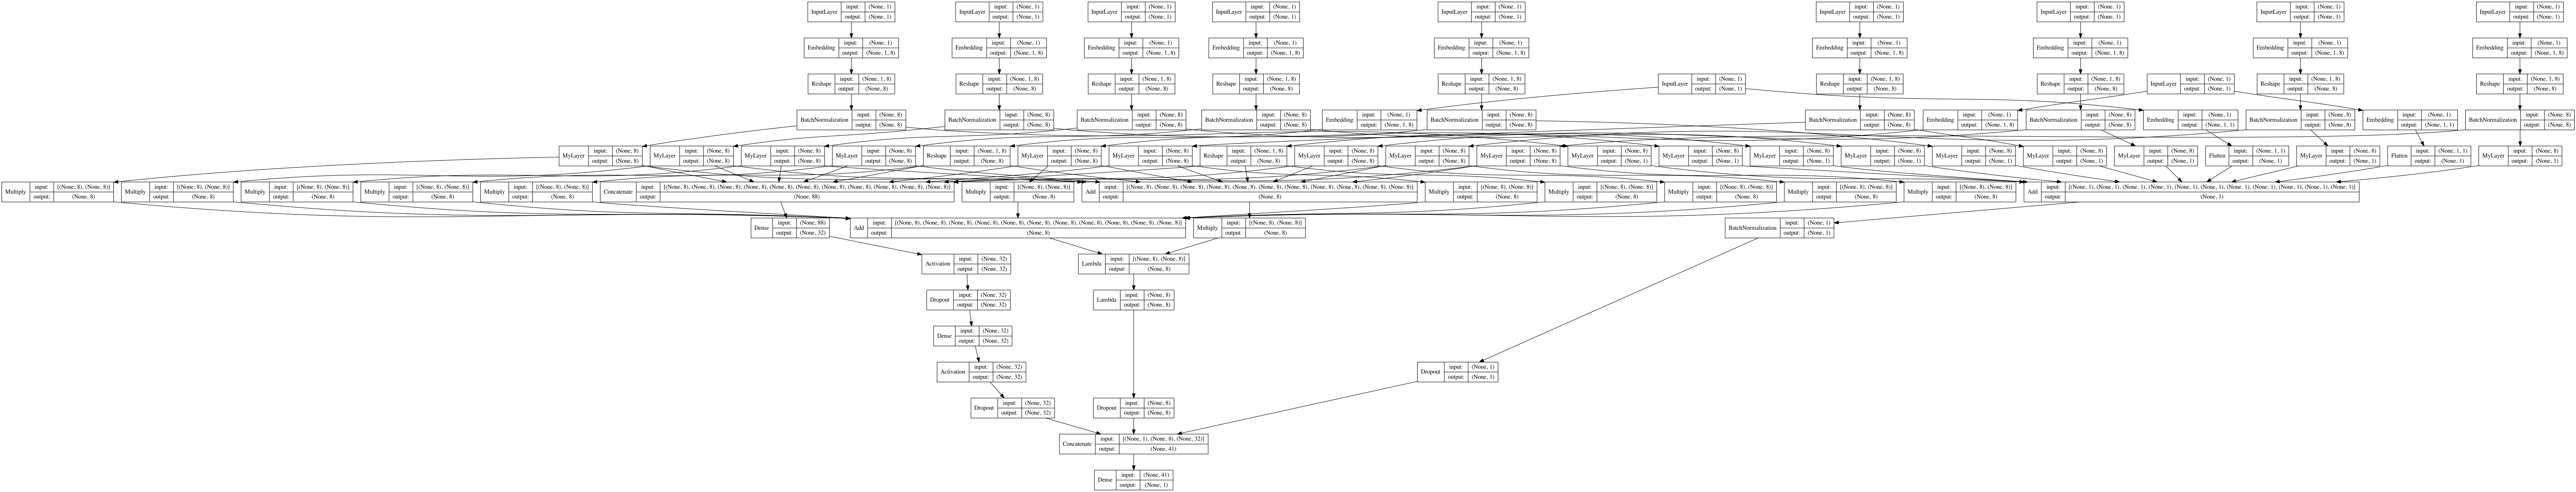

In [80]:
Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [79]:
batch_size = 210000
epochs = 300

his = model.fit(X,y,batch_size=batch_size,validation_split=0.005,epochs=epochs) # validation_data=(vali_X,vali_y),epochs=epochs)

plt.plot(his.history["loss"], label="train loss")
plt.plot(his.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show() 

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 93253 samples, validate on 469 samples
Epoch 1/300


InvalidArgumentError:  indices[43883,0] = 366 is not in [0, 174)
	 [[node embed_user_reviewcount_2/embedding_lookup (defined at /Users/apple/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_15504]

Function call stack:
keras_scratch_graph


In [ ]:
layer_name = 'embed_locationId' 
intermediate_layer_model = Model(inputs=model.input,
                             outputs=model.get_layer(layer_name).output)

locationId_latent_vector = intermediate_layer_model.predict(X)

In [ ]:
locationId_latent_vector.shape

# 유사도 아이템 추천 진행

In [45]:
def latent_to_vec(feature, location_df, h_size):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
                             
    locationId_latent_vector = intermediate_layer_model.predict(X)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']

    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId') 
    return vec

In [46]:
vec = latent_to_vec('embed_locationId', global_df, 8)
vec 

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
299152,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252
299154,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252
299502,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252
299533,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252
299536,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252,-0.061252
...,...,...,...,...,...,...,...,...
19717924,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116
19735623,-0.031116,-0.031116,0.001887,-0.031116,-0.031116,-0.031116,0.001887,0.001887
19899996,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116,-0.031116


In [47]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, item_id, top):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
        
    new_vec = vec.copy()
    sim = []
    for i in range(len(vec)):
        if i != item_id:
            sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))
    new_vec['sim'] = sim
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    top_n = new_vec.head(top)['locationId'].tolist()
    if item_id in top_n:
        top_n.remove(item_id)
    return top_n

In [48]:
def sim_item(vec, df, item_id, top):
    item_name = pickle.load(open(os.path.join("..","..","data",'item_name.pickle'),"rb"))
    
    top_id = cosim_id(vec, item_id, top)
    df = df.loc[df['locationId'].isin(top_id)]
    top_id = df.loc[df['placeType']!= 'ACCOMMODATION'].drop_duplicates(['locationId'], keep='last')
    top_id = top_id.sort_values('average_rating', ascending=False)
    top_id = top_id['locationId'].unique().tolist()
    print('input location:', item_name[item_id])
    for i in top_id: 
        print(item_name[i]) 

In [49]:
sim_item(vec, global_df, 299533, 10) 

input location: {'location.name': 'ibis styles Ambassador Seoul Gangnam'}
{'location.name': 'Mori'}
{'location.name': 'Yuk Kal Munbaedong'}
{'location.name': 'Hollys Coffee'}
{'location.name': 'Noa'}
{'location.name': 'Gangga Mugyo'}
{'location.name': 'Sapporo'}
{'location.name': 'Los Amigos'}
{'location.name': 'Aloha Table'}


In [50]:
sim_item(vec, global_df, 299533, 10) 

input location: {'location.name': 'ibis styles Ambassador Seoul Gangnam'}
{'location.name': 'Mori'}
{'location.name': 'Yuk Kal Munbaedong'}
{'location.name': 'Hollys Coffee'}
{'location.name': 'Noa'}
{'location.name': 'Gangga Mugyo'}
{'location.name': 'Sapporo'}
{'location.name': 'Los Amigos'}
{'location.name': 'Aloha Table'}


In [51]:
sim_item(vec, global_df, 19735623, 10)

input location: {'location.name': 'Toyoko Inn Seoul Yeongdeungpo'}
{'location.name': 'Nonhyeon Handmade Noodles Soup'}
{'location.name': 'Ichunbok Tuna'}
{'location.name': 'Daedo Sikdang - Wangsiblibon'}
{'location.name': 'Chicken & Beer'}
{'location.name': 'Udon Caden'}
{'location.name': 'Sulbing Daehakro'}
{'location.name': 'Mcdonalds'}
{'location.name': 'Myeonglang Hot Dog - Mok 3dong'}


In [52]:
sim_item(vec, global_df, 299152, 10)

input location: {'location.name': 'Best Western Premier Seoul Garden Hotel'}
{'location.name': 'Mori'}
{'location.name': 'Yuk Kal Munbaedong'}
{'location.name': 'Hollys Coffee'}
{'location.name': 'Noa'}
{'location.name': 'Gangga Mugyo'}
{'location.name': 'Sapporo'}
{'location.name': 'Los Amigos'}
{'location.name': 'Aloha Table'}


In [53]:
sim_item(vec, global_df, 20369565, 10) 

input location: {'location.name': 'Boutique Kyungsung'}
{'location.name': 'Korean BBQ House Raon'}
{'location.name': 'Bisa Beol Pancake Ju Yellow Beans Rice Soup'}
{'location.name': 'Mapo Mandu'}
{'location.name': 'Ssada Gimbab - Jangan'}
{'location.name': "Hunter's Moon - Jonggak"}
{'location.name': 'Tom N Toms Coffee Apgujeong Station'}
{'location.name': 'Ground Coffee'}


# 시각화

In [49]:
from sklearn.cluster import KMeans 
#from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
from bhtsne import tsne 

In [50]:
locationId_df = locationId_latent_vector.reshape(-1, 8)
kmeans = KMeans(n_clusters=10, random_state=0).fit(locationId_df)
x_all_cluster_labels = kmeans.labels_ 

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  


In [ ]:
x_all_2_embedded = tsne(locationId_df.astype('float64'))
print(x_all_2_embedded.shape)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x_all_2_embedded[:, 0], x_all_2_embedded[:, 1], c=x_all_cluster_labels)
plt.colorbar()
plt.show()